# Fast Axiomatic Attribution for Neural Networks

The Fast Axiomatic Attribution paper introduced a new term for neural networks called X-DNN (Bias-Free Deep Neural Networks), where the bias terms are removed from all layers to improve attribution quality and interpretability while maintaining similar performance to standard deep networks.X-DNN removes all bias terms from convolutional and fully connected layers to enforce homogeneity, ensuring more faithful attributions while maintaining comparable accuracy through Batch Normalization,which is good for explainability.
It also intoduces X-Gradient (X-Grad) which is an efficient gradient-based attribution method that leverages X-DNN to highlight input features that contribute most to the model’s prediction, offering a computationally efficient alternative to Integrated Gradients.

## Problems with Older methods like IG and Smooth Grad :
- It is compuatationally expensive as IG has to loop over many interpolated images while smooth Grad has to compute for every noise added pictures and then compute average of it , but X grad is done with one forward an backward loop which can be used in realtime applications.
- Both IG and smooth struggle with bias terms they may assign importance to unimportant regions due to model biases but X grad only focuses on important regions of the object which is thus useful for many precision use cases.

### **Homogeneity in X-DNN**  

X-DNN follows the **non-negative homogeneity rule**, which states:  

$$
F(\alpha x) = \alpha F(x), \quad \text{for any } \alpha > 0
$$

This means that **if the input is scaled, the attribution scales proportionally**, ensuring consistent and interpretable feature importance. By **removing bias terms**, X-DNN preserves this property, preventing attributions from being influenced by constant shifts and making **X-Gradient more reliable** for explaining model decisions. 

### Algorithm Steps for computing X-Grad:

1. **Define X-DNN Model: (Using VGG16)**
   - **Overview:** The paper discusses a pretrained X-VGG16 model trained on ImageNet used to compute X-Grad, ensuring bias removal from all layers and employing ReLU activations to maintain nonnegative homogeneity.
   - **Extracted Pretrained Model Structure:**
     ```
     xvgg16_model_best.pth/
     │
     ├── archive/
     │   ├── data/         # contains tensor data files for the model
     │   ├── data.pkl      # Serialized metadata and tensor references
     │   └── version       # Version information of the model or serialization format
     ```

2. **Forward Pass:**
   - Description of what occurs during the forward pass...
 

**3. Backward Pass:**  
- Compute the **gradient** of the model output w.r.t. the input:  
  $$  
  \frac{\partial F(x)}{\partial x}  
  $$

**4. Compute X-Gradient:**  
- This optained fro IG and the proff is mentioned below
- Multiply the input \( x \) by the computed gradient:  
  $$  
  XG(x) = x \times \frac{\partial F(x)}{\partial x}  
  $$

**5. Interpret Feature Attributions:**  
- The resulting **X-Gradient map** highlights important features.  
- Features with **higher values** contribute more to the model’s prediction.  
 
---


## Limitatons of X -Grad:

- Tanh and Sigmoid functions are not homogeneous this limits XG to networks that strictly use ReLU-based or piecewise linear activations.
- XG applies only to differentiable models.It cannot be used with decision trees, rule-based models, or non-differentiable architectures.

## The model structure of X - VGG16 with the bias removed and trained

In [19]:
print(model)


XVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): 

## Custom Unpickler to load
- We used a custom unpickler because PyTorch sometimes saves large tensors in separate binary files and stores references in the .pkl file, which the default pickle loader cannot handle. The CustomUnpickler intercepts these references, loads the raw tensor data from disk, and reconstructs them using torch.

In [65]:
import torch
import pickle
import os
import numpy as np

pkl_path = "C:/Users/VISHNU/xvgg16_model_best.pth/archive/data.pkl"
checkpoint_folder = "C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/"

class CustomUnpickler(pickle.Unpickler):
    def persistent_load(self, saved_id):
        """ Handles loading of persistent tensor storage """
        if isinstance(saved_id, tuple) and saved_id[0] == 'storage':
            _, storage_type, storage_id, device_str, size = saved_id
            
            storage_path = os.path.join(checkpoint_folder, storage_id)
            print(f"Loading raw tensor from {storage_path} (size: {size})")

            try:
                with open(storage_path, "rb") as f:
                    raw_data = np.frombuffer(f.read(), dtype=np.float32)  

                storage = torch.FloatStorage.from_buffer(raw_data, byte_order="native")

                return storage
            except Exception as e:
                raise RuntimeError(f" Error loading tensor from {storage_path}: {e}")

        raise RuntimeError(f" Unrecognized persistent ID format: {saved_id}")

with open(pkl_path, "rb") as f:
    checkpoint = CustomUnpickler(f).load()

print("Checkpoint keys:", checkpoint.keys())

print(" Checking loaded weights...")
for name, param in checkpoint["state_dict"].items():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")
    break 


Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464542256912 (size: 1728)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464537680096 (size: 36864)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464541718288 (size: 73728)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464541627152 (size: 147456)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464541248144 (size: 294912)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464541026528 (size: 589824)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464542225216 (size: 589824)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464551140496 (size: 1179648)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best.pth/archive/data/94464542589904 (size: 2359296)
Loading raw tensor from C:/Users/VISHNU/xvgg16_model_best

In [66]:
import torch
import torch.nn as nn
from xvgg import xvgg16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = xvgg16(pretrained=False).to(device)

new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}

model.load_state_dict(new_state_dict, strict=False)
model.eval() 

print(" XVGG16 Model Loaded Successfully!")

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"{name}: mean={param.mean().item()}, std={param.std().item()}") # Just confirm its loaded correctly
        break


 XVGG16 Model Loaded Successfully!
features.0.weight: mean=-0.00024375181237701327, std=0.2843324840068817


In [67]:
from torchvision import transforms
from PIL import Image

# Image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0) 
    return image.to(device)


## **4. Computing X-Gradient:**  
- Multiply the input \( x \) by the computed gradient:  
  $$  
  XG(x) = x \times \frac{\partial F(x)}{\partial x}  
  $$


In [68]:
import numpy as np
import matplotlib.pyplot as plt

imagenet_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(imagenet_labels_url).text.splitlines()

def compute_x_gradient(model, x_input):
    x_input.requires_grad = True  # Enable gradient computation
    
    output = model(x_input)
    predicted_class = torch.argmax(output, dim=1).item()
    class_name = imagenet_classes[predicted_class]
    print(f"Predicted Class: {predicted_class} - {class_name}")
    
    target_score = output[:, predicted_class]
    
    model.zero_grad()
    target_score.backward()

    x_gradient = x_input.grad.abs().max(dim=1, keepdim=True)[0]
    return x_gradient, predicted_class, class_name


In [69]:
def visualize_x_gradients(images, gradients, class_names):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i in range(num_images):
        x_grad_np = gradients[i].squeeze().detach().cpu().numpy()
        x_grad_np = (x_grad_np - x_grad_np.min()) / (x_grad_np.max() - x_grad_np.min())  # Normalize
        
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f'Original Image\nPredicted: {class_names[i]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(x_grad_np, cmap='gray')  # Use grayscale colormap
        axes[i, 1].set_title("X-Gradient Saliency Map")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()



Processing: C:\Users\VISHNU\Downloads\africanelephant.jpg
Predicted Class: 101 - tusker

Processing: C:\Users\VISHNU\Downloads\pineapple.JPEG
Predicted Class: 953 - pineapple

Processing: C:\Users\VISHNU\Downloads\cup.jpg
Predicted Class: 504 - coffee mug

Processing: C:\Users\VISHNU\Downloads\soccer.jpg
Predicted Class: 805 - soccer ball


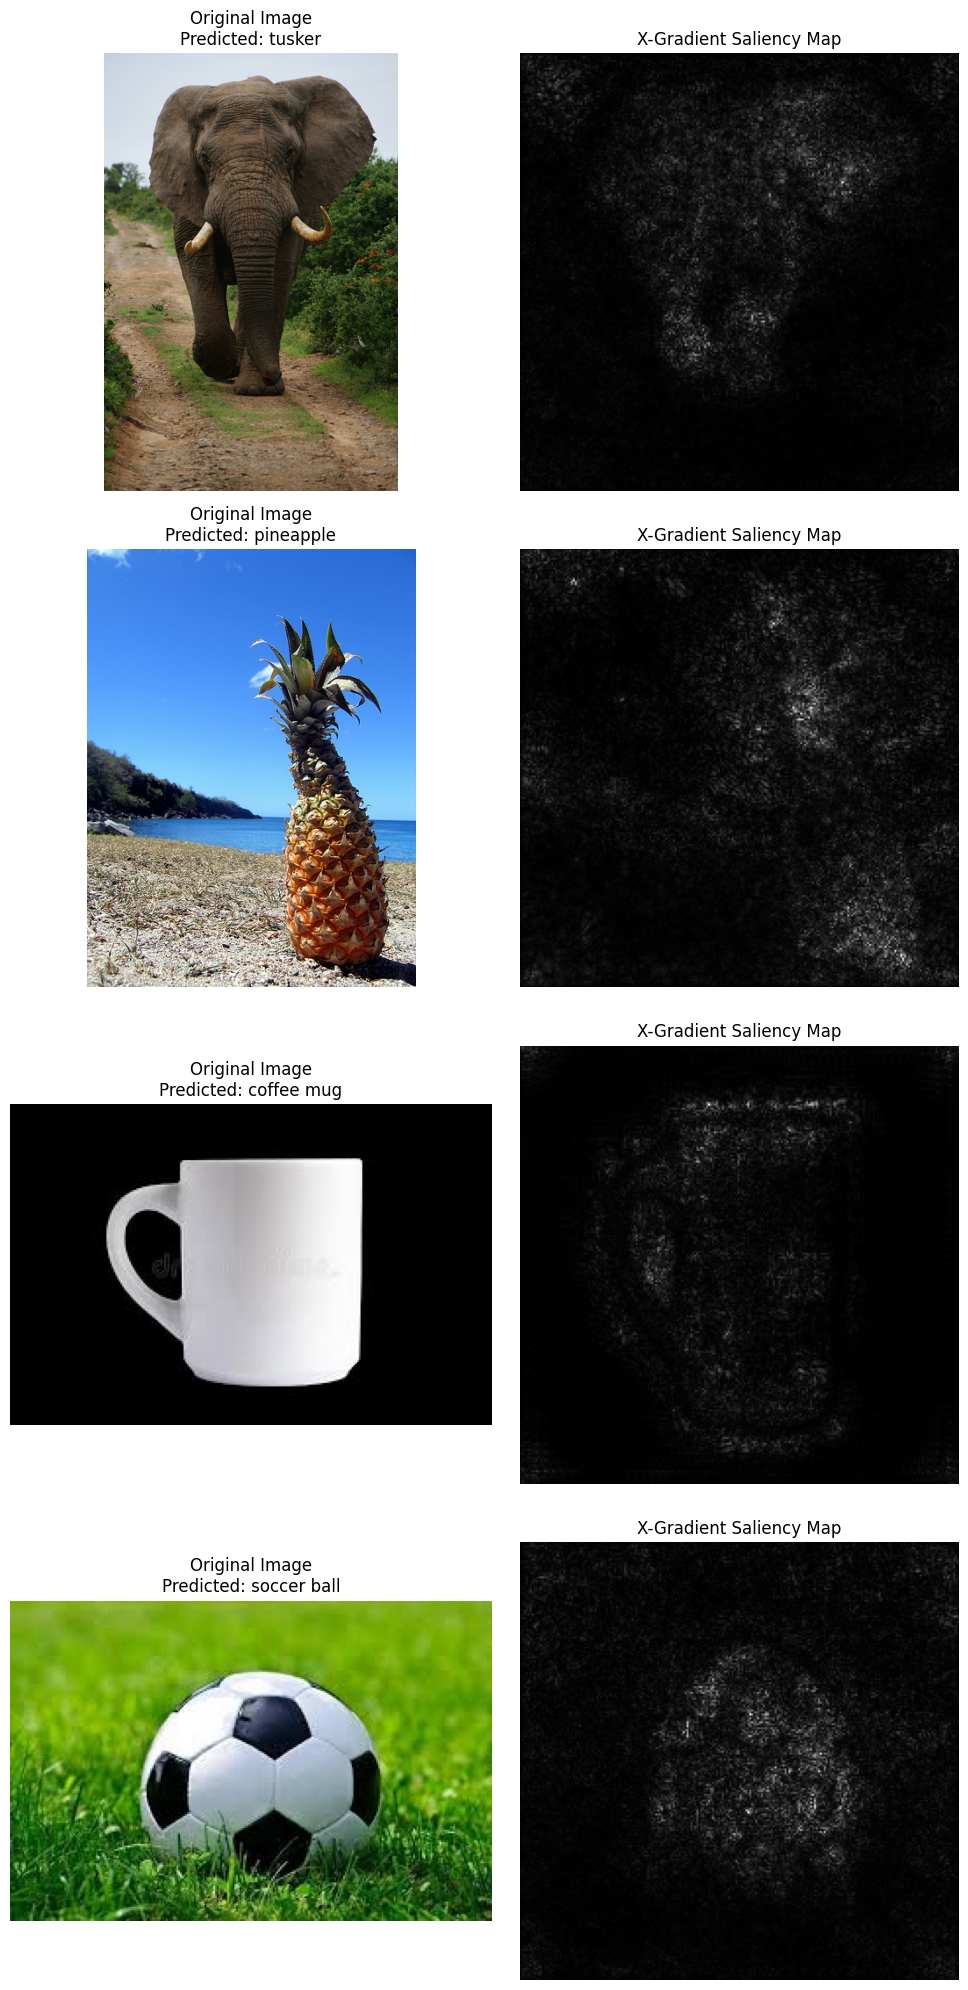

In [73]:
def main(image_paths):
    images = []
    gradients = []
    class_names = []

    for image_path in image_paths:
        print(f"\nProcessing: {image_path}")
        
        x_input = preprocess_image(image_path)
        x_gradient, predicted_class, class_name = compute_x_gradient(model, x_input)

        original_image = Image.open(image_path).convert('RGB')

        images.append(original_image)
        gradients.append(x_gradient)
        class_names.append(class_name)

    # Visualize all images
    visualize_x_gradients(images, gradients, class_names)

# Run the script
if __name__ == "__main__":
    image_paths = [
        r"C:\Users\VISHNU\Downloads\africanelephant.jpg",
        r"C:\Users\VISHNU\Downloads\pineapple.JPEG",
        r"C:\Users\VISHNU\Downloads\cup.jpg",
        r"C:\Users\VISHNU\Downloads\soccer.jpg",
        ]
    
    main(image_paths)
